## 导包

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 导入数据

In [2]:
# use numpy to load dataset
dataset = np.loadtxt('./dataset/stock_2.csv', delimiter=",", dtype="str")

In [3]:
print(dataset.shape)

(6110, 10)


In [4]:
dataset[:5, :]

array([['index_code', 'date', 'open', 'close', 'low', 'high', 'volume',
        'money', 'change', 'label'],
       ['sh000001', '1990/12/20', '104.3', '104.39', '99.98', '104.39',
        '197000', '85000', '0.044108822', '109.13'],
       ['sh000001', '1990/12/21', '109.07', '109.13', '103.73', '109.13',
        '28000', '16100', '0.045406648', '114.55'],
       ['sh000001', '1990/12/24', '113.57', '114.55', '109.13', '114.55',
        '32000', '31100', '0.049665537', '120.25'],
       ['sh000001', '1990/12/25', '120.09', '120.25', '114.55', '120.25',
        '15000', '6500', '0.04975993', '125.27']], dtype='<U12')

In [5]:
# pandas 导入数据
dataset_pd = pd.read_csv('./dataset/stock_2.csv')

In [6]:
dataset_pd.head(5)

,index_code,date,open,close,low,high,volume,money,change,label
0,sh000001,1990/12/20,104.30,104.39,99.98,104.39,197000.0,85000.0,0.044109,109.13
1,sh000001,1990/12/21,109.07,109.13,103.73,109.13,28000.0,16100.0,0.045407,114.55
2,sh000001,1990/12/24,113.57,114.55,109.13,114.55,32000.0,31100.0,0.049666,120.25
3,sh000001,1990/12/25,120.09,120.25,114.55,120.25,15000.0,6500.0,0.049760,125.27
4,sh000001,1990/12/26,125.27,125.27,120.25,125.27,100000.0,53700.0,0.041746,125.28


In [7]:
# pandas 的数据 转成 numpy 的 矩阵
dataset_np = dataset_pd.values

In [8]:
dataset_np.shape

(6109, 10)

In [9]:
dataset_np[:5, :]

array([['sh000001', '1990/12/20', 104.3, 104.39, 99.98, 104.39, 197000.0,
        85000.0, 0.044108822, 109.13],
       ['sh000001', '1990/12/21', 109.07, 109.13, 103.73, 109.13,
        28000.0, 16100.0, 0.045406648, 114.55],
       ['sh000001', '1990/12/24', 113.57, 114.55, 109.13, 114.55,
        32000.0, 31100.0, 0.049665537, 120.25],
       ['sh000001', '1990/12/25', 120.09, 120.25, 114.55, 120.25,
        15000.0, 6500.0, 0.04975993, 125.27],
       ['sh000001', '1990/12/26', 125.27, 125.27, 120.25, 125.27,
        100000.0, 53700.0, 0.041746362, 125.28]], dtype=object)

## 切出 X 和 y

In [10]:
X = dataset_np[:, 2:-1].astype(np.float32)
y = dataset_np[:, -1:].astype(np.float32)

In [11]:
print(X.shape)
print(X.dtype)

(6109, 7)
float32


In [12]:
print(y.shape)
print(y.dtype)

(6109, 1)
float32


### split training set and testing set

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

### 标准化

In [14]:
from sklearn.preprocessing import StandardScaler

standard = StandardScaler()
standard.fit(X_train)

X_train_standard = standard.transform(X_train)
X_test_standard = standard.transform(X_test)

### 设定超参数

In [15]:
input_size = X.shape[1] # 7
ouput_size = y.shape[1] # 1
hidden_size = 32 # 神经元的个数为 32
learning_rate = 1e-2
EPOCH = 10000

### 搭建模型 —— 全连接神经网络

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hidden1 = nn.Linear(input_size, hidden_size) # [-1, 7] * [7, 32] ==> [-1, 32]
        self.hidden2 = nn.Linear(hidden_size, hidden_size) # [-1, 32] * [32, 32] ==> [-1, 32]
        
        self.predict = nn.Linear(hidden_size, ouput_size) # [-1, 32] * [32, 1] ==> [-1, 1]
    
    def forward(self, x):
        # x (X_train 和 X_test) == [-1, 7]
        # 真正搭建网络的地方
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        
        out = self.predict(x)
        
        return out

In [17]:
net = Net()
net

Net(
  (hidden1): Linear(in_features=7, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (predict): Linear(in_features=32, out_features=1, bias=True)
)

### 优化器，损失函数

In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

### 开始训练我们的模型

In [19]:
Trian_losses = []

for epoch in range(EPOCH):
    input_x = Variable(torch.FloatTensor(X_train_standard)) # 特征 array --> tensor --> Variable
    input_y = Variable(torch.FloatTensor(y_train)) # 标签 将 array --> tensor --> Variable
    
    y_pred = net(input_x)
    
    loss = loss_func(input_y, y_pred)
    Trian_losses.append(loss.data.numpy()) # 将 tensor 转成 numpy 的数值
    
    # 非常标准的一套流程
    optimizer.zero_grad() # 梯度归 0
    loss.backward() # 求梯度
    optimizer.step() # 把新的梯度传进去
    
    # -------------------------------- #
    if (epoch+1) % 50 == 0:
        print('Trianing....Epoch: ', (epoch+1), 'Loss: ', loss.data.numpy())
    
    # ------------ 使用 测试集 去查看 测试集的 效果------------------#
    # 每隔 500 个 epoch,就导入 测试集 去查看 模型 的效果
    if (epoch+1) % 500 == 0:
        test_x = Variable(torch.FloatTensor(X_test_standard)) # 特征 array --> tensor --> Variable
        test_y = Variable(torch.FloatTensor(y_test)) # 标签 将 array --> tensor --> Variable

        test_pred = net(test_x)

        test_loss = loss_func(test_y, test_pred)

        # 非常标准的一套流程
        optimizer.zero_grad() # 梯度归 0
        test_loss.backward() # 求梯度
        optimizer.step() # 把新的梯度传进去
        print('---------------------------------------')
        print('Testing....Epoch: ', (epoch+1), 'Loss: ', test_loss.data.numpy())
        print('---------------------------------------')

Trianing....Epoch:  50 Loss:  3263116.5
Trianing....Epoch:  100 Loss:  680832.7
Trianing....Epoch:  150 Loss:  187495.23
Trianing....Epoch:  200 Loss:  88337.26
Trianing....Epoch:  250 Loss:  48716.492
Trianing....Epoch:  300 Loss:  23553.512
Trianing....Epoch:  350 Loss:  10728.194
Trianing....Epoch:  400 Loss:  5240.492
Trianing....Epoch:  450 Loss:  2972.6516
Trianing....Epoch:  500 Loss:  2023.6671
---------------------------------------
Testing....Epoch:  500 Loss:  1996.9788
---------------------------------------
Trianing....Epoch:  550 Loss:  1532.082
Trianing....Epoch:  600 Loss:  1098.6709
Trianing....Epoch:  650 Loss:  927.11237
Trianing....Epoch:  700 Loss:  876.1301
Trianing....Epoch:  750 Loss:  861.21967
Trianing....Epoch:  800 Loss:  855.46826
Trianing....Epoch:  850 Loss:  851.328
Trianing....Epoch:  900 Loss:  848.1492
Trianing....Epoch:  950 Loss:  845.4527
Trianing....Epoch:  1000 Loss:  842.87213
---------------------------------------
Testing....Epoch:  1000 Loss:

Trianing....Epoch:  7800 Loss:  633.0286
Trianing....Epoch:  7850 Loss:  632.90283
Trianing....Epoch:  7900 Loss:  632.7299
Trianing....Epoch:  7950 Loss:  632.83997
Trianing....Epoch:  8000 Loss:  632.4459
---------------------------------------
Testing....Epoch:  8000 Loss:  1077.5686
---------------------------------------
Trianing....Epoch:  8050 Loss:  633.84393
Trianing....Epoch:  8100 Loss:  632.30145
Trianing....Epoch:  8150 Loss:  632.16473
Trianing....Epoch:  8200 Loss:  632.04254
Trianing....Epoch:  8250 Loss:  631.83575
Trianing....Epoch:  8300 Loss:  631.6939
Trianing....Epoch:  8350 Loss:  631.54785
Trianing....Epoch:  8400 Loss:  631.80194
Trianing....Epoch:  8450 Loss:  631.60345
Trianing....Epoch:  8500 Loss:  631.0641
---------------------------------------
Testing....Epoch:  8500 Loss:  1071.9113
---------------------------------------
Trianing....Epoch:  8550 Loss:  631.13324
Trianing....Epoch:  8600 Loss:  630.75037
Trianing....Epoch:  8650 Loss:  630.59717
Trianin

## 让模型能够 收敛 的方法
### 1、加大到 EPOCH
### 2、减小学习率
### 3、增加模型的复杂度，增加多一些网络层次，增加神经元个数

## 验证模型的 好坏，可视化

In [20]:
# 1、把 tensor 转为 array
prediction = test_pred.data.numpy()

In [21]:
type(prediction)

numpy.ndarray

In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def caculate(y_true, y_predict):
    print('MSE: ', mean_squared_error(y_true, y_predict))
    print('RMSE: ', np.sqrt(mean_squared_error(y_true, y_predict)))
    print('MAE: ', mean_absolute_error(y_true, y_predict))
    print('R2: ', r2_score(y_true, y_predict))

In [23]:
caculate(y_test, prediction)

MSE:  1079.0929
RMSE:  32.84955
MAE:  15.836557
R2:  0.9990337038808349


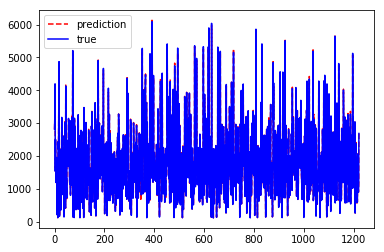

In [24]:
plt.plot(range(len(prediction)), prediction, 'r--', label="prediction")
plt.plot(range(len(y_test)), y_test, 'b', label="true")
plt.legend()
plt.show()